Le rapport est en ligne en pdf sur github.

Il n'y a pas de code dans le rapport mais il décrit ce qu'on cherche à accomplir et interprète les résultats du code.

# Lemmatisation (projet 3)

Professeur : Alexis Nasr

Master 1

Aix-Marseille Université

On cherche à créer un modèle permettant de lemmatiser des mots. Pour cela, comme on veut déceler les relations pouvant relier des évènements arbitrairement distants, on utilise un réseau de neurone récurrent (RNN), de type transducteur c'est-à-dire qui lit une séquence (le mot à lemmatiser) et en produit une autre (le lemme prédit).
Le lemme est la forme canonique d'un mot (par exemple le lemme de « mangeront » est « manger »).

Le réseau prend en entrée des séquences de caractères représentés sous la forme de vecteurs onehot.

On se focalise sur 3 catégories grammaticales : adjectif (A), nom (N) et verbe (V).

On va créer trois types de lemmatiseurs. Premièrement, le lemmatiseur catégoriel ne prendra en compte que des mots d'une même catégorie grammaticale, on va donc en faire trois, un pour chaque catégorie d'intérêt. Deuxièmement, on va créer un lemmatiseur général qui prend en compte la catégorie. Et troisièmement, on fera la version la plus réaliste du lemmatiseur qui ne suppose pas de connaître la catégorie de la forme à lemmatiser.

On fait l'hypothèse qu'on obtiendra la meilleure performance pour le premier modèle (lemmatiseur catégoriel).

In [ ]:
 %%bash
wget https://pageperso.lis-lab.fr/alexis.nasr/Data/data_lemmatisation.tgz
tar xvfz data_lemmatisation.tgz

data/
data/lemmatisation_test_A.txt
data/lemmatisation_test_V.txt
data/lemmatisation_train_N.txt
data/lemmatisation_train_A.txt
data/data.tgz
data/alphabet.txt
data/lemmatisation_train_V.txt
data/lemmatisation_test_N.txt
data/run.sh
data/lemmatisation_train_origin.txt
data/lemmatisation_test.txt
data/lemmatisation_test_origin.txt
data/lemmatisation_train.txt
data/lemmatisation_data.tgz


--2024-05-05 15:01:05--  https://pageperso.lis-lab.fr/alexis.nasr/Data/data_lemmatisation.tgz
Resolving pageperso.lis-lab.fr (pageperso.lis-lab.fr)... 139.124.22.27
Connecting to pageperso.lis-lab.fr (pageperso.lis-lab.fr)|139.124.22.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9083030 (8.7M) [application/x-gzip]
Saving to: ‘data_lemmatisation.tgz.3’

     0K .......... .......... .......... .......... ..........  0%  221K 40s
    50K .......... .......... .......... .......... ..........  1%  444K 30s
   100K .......... .......... .......... .......... ..........  1%  144M 20s
   150K .......... .......... .......... .......... ..........  2%  445K 20s
   200K .......... .......... .......... .......... ..........  2%  226M 16s
   250K .......... .......... .......... .......... ..........  3%  287M 13s
   300K .......... .......... .......... .......... ..........  3%  254M 11s
   350K .......... .......... .......... .......... ..........  4% 91.6M 10

# **Fonction EncodeDecode**

In [ ]:
import sys

class EncodeDecode :
    size = 0
    valToCode = None #dictionnaire : pour associer une valeur à son code correspondant (donc 'é' donnera 14)
    codeToVal = None #liste : pour associer un code à sa valeur correspondante (donc en indice 14, il y aura 'é')

    def __init__(self, fileName=None, listVal=None, maxVal=None):
        self.size = 0
        self.valToCode = {}
        self.codeToVal = []
        if fileName != None : # on lit le fichier et ça ajoute chaque valeur au dictionnaire
            f = open(fileName, "r")
            for line in f:
                val = line.rstrip('\n')
                self.valToCode[val] = self.size
                self.codeToVal.append(val)
                self.size += 1

        elif listVal != None: #on ajoute chaque valeur au dictionnaire
            for val in listVal:
                self.valToCode[val] = self.size
                self.codeToVal.append(val)
                self.size += 1

        elif maxVal != None:
            for val in range(maxVal + 1):
                self.valToCode[val] = self.size
                self.codeToVal.append(val)
                self.size += 1


    def encode(self, val): # retourne le code de la valeur ('é' => 14)
        if val not in self.valToCode.keys() :
            print("no code for ", val)
            return None
        return self.valToCode[val]

    def decode(self, code): # retourne la valeur du code ('14' => é)
        if code >= self.size :
            print("no val for code ", code)
            return None
        return self.codeToVal[code]

    def oneHotEncode(self, val): # 'a' sera [1 0 0 0 0 ...]
        tab = [0] * self.size
        tab[self.encode(val)] = 1
        return tab

    def argmax(self, l): # prend une liste en entrée et retourne l'indice de la valeur maximale de la liste
        index, max_val = -1, -1
        for i in range(len(l)):
            if l[i] > max_val:
                index, max_val = i, l[i]
        return index

    def oneHotDecode(self, l): # prend une liste encodée en one-hot en entrée, la décode en sa valeur correspondante en utilisant les méthodes argmax et decode, et retourne la valeur décodée
        return self.decode(self.argmax(l))




# Fonction Test EncodeDecode

In [ ]:
#from EncodeDecode import EncodeDecode

ed = EncodeDecode("data/alphabet.txt") # création de la classe ed (e encode, d decode)

print(ed.encode('é')) # donne l'indice de ce caractère, soit 14
oneHot = ed.oneHotEncode('é') #one hot encoding du vecteur 'é' <=> on a 1 à l'indice 15
print(oneHot)
print(ed.oneHotDecode(oneHot)) # là on devrait obtenir 'é'


14
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
é


# Création fonction qui lit les fichiers

In [ ]:
# pour chaque lettre on construit un vecteur one-hot vector et on le met dans une liste, puis faudra créer un array

import numpy as np

def lecture_fichier(fichier):

  try:
    fic = open(fichier, 'r')
  except IOError:
    print("le fichier", fichier, "n'existe pas")
    return None
  LX = [] # liste contenant des listes de vecteurs OneHot pour chaque mot de la colonne gauche (forme)
  LY = [] # pareil pour colonne milieu (le lemme)
  for line in fic:
    line = line.rstrip() # supprime les espaces en fin de ligne
    line = line.strip('\n\r') #supprime les caractères '\n' (nouvelle ligne) et '\r' (retour chariot)
    (forme, lemme, cat) = line.split()
    X = [] # liste contenant les vecteurs OneHot de chaque lettre de la forme (du mot de la colonne gauche)
    for c in forme: # (c : caractère)
      oneHot = ed.oneHotEncode(c)
      X.append(oneHot)
    LX.append(X) #on ajoute la liste des vecteurs OneHot d'un mot à LX, donc LX contenant des listes de vecteurs OneHot pour chaque mot de la colonne gauche (forme)
    Y = []
    for c in lemme:
      oneHot = ed.oneHotEncode(c)
      Y.append(oneHot)
    LY.append(Y)

  return np.array(LX), np.array(LY)


# I. Lemmatiseur catégoriel

On met en forme les données train

In [ ]:
x_trainA, y_trainA = lecture_fichier('data/lemmatisation_train_A.txt')
x_trainN, y_trainN = lecture_fichier('data/lemmatisation_train_N.txt')
x_trainV, y_trainV = lecture_fichier('data/lemmatisation_train_V.txt')

In [ ]:
print(x_trainA.shape)
# 18283 = nombre d'exemples d'entraînement (<=> nombre de lignes du fichier train_A)
# 25 = nombre de caractères sur chaque colonne (le mot et les #). C'est la longueur de chaque vecteur encodé.
# 66 = taille de l'alphabet

(18283, 25, 66)


# Construction du modèle RNN

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Activation, Dropout

input_length = 25 # nb caractères sur chaque colonne (le mot et les #)
input_dim = 66 # nb caractères alphabet

model = Sequential()
model.add(GRU(
    units = 64, # dimension du vecteur d'état
    activation="tanh", # fonction d'activation de l'état interne
    recurrent_activation="sigmoid", # fonction d'activation des filtres
    use_bias=True, # ajout d'un biais
    return_sequences=True,
    return_state=False,
    input_shape=(input_length, input_dim)))

# ajout d'une couche dense avec une activation softmax pour la prédiction de chaque caractère
model.add(Dense(units=66, activation='softmax')) # 66 comme nombre de classes
# units = 66 <=> 66 neurones en sortie ce qui correspond au nb total de caractères de notre alphabet. Units définit la dimension de l'espace de sortie de la couche.

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

On met en forme les données de test

In [ ]:
x_testA, y_testA = lecture_fichier('data/lemmatisation_test_A.txt')
x_testN, y_testN = lecture_fichier('data/lemmatisation_test_N.txt')
x_testV, y_testV = lecture_fichier('data/lemmatisation_test_V.txt')

1. Catégorie A

Entraînement du modèle avec les données train A

In [ ]:
# facultatif (à ne pas forcément exécuter)
# test : afficher les prédictions avant l'entraînement (donc on a des séquences de lettres aléatoires)
predictions_trainA_avant = model.predict(x_trainA)
for i in range(len(predictions_trainA_avant)):
  print("Mot à lemmatiser:", ''.join([ed.oneHotDecode(one_hot) for one_hot in x_trainA[i]]))
  print("Lemme prédit:", ''.join([ed.oneHotDecode(one_hot) for one_hot in predictions_trainA[i]]))
  print()

On va créer un modèle par lemmatiseur catégoriel

In [ ]:
from keras.models import clone_model
modelA = clone_model(model) # pour séparer les 3 modèles
modelA.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # besoin de le recompiler
modelA.fit(x_trainA, y_trainA,epochs=10, batch_size=128)

Epoch 1/10
143/143 [==============================] - 9s 48ms/step - loss: 1.6134 - accuracy: 0.7130
Epoch 2/10
143/143 [==============================] - 5s 37ms/step - loss: 0.6522 - accuracy: 0.8890
Epoch 3/10
143/143 [==============================] - 6s 45ms/step - loss: 0.1928 - accuracy: 0.9748
Epoch 4/10
143/143 [==============================] - 6s 40ms/step - loss: 0.0905 - accuracy: 0.9829
Epoch 5/10
143/143 [==============================] - 6s 42ms/step - loss: 0.0628 - accuracy: 0.9870
Epoch 6/10
143/143 [==============================] - 6s 44ms/step - loss: 0.0493 - accuracy: 0.9889
Epoch 7/10
143/143 [==============================] - 5s 38ms/step - loss: 0.0412 - accuracy: 0.9900
Epoch 8/10
143/143 [==============================] - 7s 47ms/step - loss: 0.0352 - accuracy: 0.9907
Epoch 9/10
143/143 [==============================] - 6s 44ms/step - loss: 0.0304 - accuracy: 0.9921
Epoch 10/10
143/143 [==============================] - 7s 47ms/step - loss: 0.0263 - accura

In [ ]:
# facultatif (à ne pas forcément exécuter)
# après l'entraînement du modèle, on peut faire comme avant et afficher les prédictions qu'il fait :

predictions_trainA_apres = modelA.predict(x_trainA)
for i in range(len(predictions_trainA_apres)):
  print("Mot à lemmatiser:", ''.join([ed.oneHotDecode(one_hot) for one_hot in x_trainA[i]]))
  print("Lemme prédit:", ''.join([ed.oneHotDecode(one_hot) for one_hot in predictions_trainA_apres[i]]))
  print()

# on voit bien que le modèle a bien été entraîné : les lemmes prédits sont très proches des lemmes attendus (égaux ou manquant une ou 2 lettres)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Lemme prédit: premier##################

Mot à lemmatiser: petits###################
Lemme prédit: petit####################

Mot à lemmatiser: relatif##################
Lemme prédit: relatif##################

Mot à lemmatiser: première#################
Lemme prédit: premier##################

Mot à lemmatiser: première#################
Lemme prédit: premier##################

Mot à lemmatiser: cher#####################
Lemme prédit: cher#####################

Mot à lemmatiser: inattendue###############
Lemme prédit: inattendue###############

Mot à lemmatiser: salariale################
Lemme prédit: salarial#################

Mot à lemmatiser: national#################
Lemme prédit: national#################

Mot à lemmatiser: publics##################
Lemme prédit: public###################

Mot à lemmatiser: rétroactif###############
Lemme prédit: rétroactif###############

Mot à lemmatiser: supérieure###

Evaluation du modèle sur les données test A

In [ ]:
scoreA = modelA.evaluate(x_testA, y_testA) # verbose=0 : Cela signifie "silencieux" et aucune sortie n'est affichée pendant l'évaluation. | verbose=1 : C'est la valeur par défaut. Pendant l'évaluation, une barre de progression est affichée, indiquant le nombre d'échantillons évalués. | verbose=2 : Cette option est similaire à verbose=1, mais affiche également une ligne par époque indiquant la perte (loss) et les métriques d'évaluation.
print('Test loss:', scoreA[0])
print('Test accuracy:', scoreA[1])

76/76 [==============================] - 1s 7ms/step - loss: 0.0236 - accuracy: 0.9949
Test loss: 0.02360861748456955
Test accuracy: 0.9949461221694946


2. Catégorie N

Entraînement du modèle avec les données train N

In [ ]:
modelN = clone_model(model)
modelN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
modelN.fit(x_trainN, y_trainN,epochs=10, batch_size=128)

Epoch 1/10
512/512 [==============================] - 25s 45ms/step - loss: 0.7156 - accuracy: 0.8825
Epoch 2/10
512/512 [==============================] - 21s 41ms/step - loss: 0.0667 - accuracy: 0.9892
Epoch 3/10
512/512 [==============================] - 24s 46ms/step - loss: 0.0395 - accuracy: 0.9917
Epoch 4/10
512/512 [==============================] - 22s 43ms/step - loss: 0.0305 - accuracy: 0.9926
Epoch 5/10
512/512 [==============================] - 23s 45ms/step - loss: 0.0244 - accuracy: 0.9932
Epoch 6/10
512/512 [==============================] - 27s 53ms/step - loss: 0.0208 - accuracy: 0.9939
Epoch 7/10
512/512 [==============================] - 33s 64ms/step - loss: 0.0186 - accuracy: 0.9944
Epoch 8/10
512/512 [==============================] - 22s 44ms/step - loss: 0.0170 - accuracy: 0.9948
Epoch 9/10
512/512 [==============================] - 27s 52ms/step - loss: 0.0157 - accuracy: 0.9951
Epoch 10/10
512/512 [==============================] - 21s 41ms/step - loss: 0.014

Evaluation du modèle sur les données test N

In [ ]:
scoreN = modelN.evaluate(x_testN, y_testN)
print('Test loss:', scoreN[0])
print('Test accuracy:', scoreN[1])

263/263 [==============================] - 2s 7ms/step - loss: 0.0124 - accuracy: 0.9957
Test loss: 0.012395978905260563
Test accuracy: 0.9957183599472046


3. Catégorie V

Entraînement du modèle avec les données train V

In [ ]:
modelV = clone_model(model)
modelV.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
modelV.fit(x_trainV, y_trainV,epochs=10, batch_size=128)

Epoch 1/10
238/238 [==============================] - 31s 61ms/step - loss: 1.1894 - accuracy: 0.7678
Epoch 2/10
238/238 [==============================] - 11s 44ms/step - loss: 0.3817 - accuracy: 0.9099
Epoch 3/10
238/238 [==============================] - 9s 40ms/step - loss: 0.2040 - accuracy: 0.9416
Epoch 4/10
238/238 [==============================] - 10s 44ms/step - loss: 0.1387 - accuracy: 0.9588
Epoch 5/10
238/238 [==============================] - 11s 44ms/step - loss: 0.1072 - accuracy: 0.9668
Epoch 6/10
238/238 [==============================] - 11s 45ms/step - loss: 0.0881 - accuracy: 0.9716
Epoch 7/10
238/238 [==============================] - 11s 45ms/step - loss: 0.0746 - accuracy: 0.9755
Epoch 8/10
238/238 [==============================] - 9s 39ms/step - loss: 0.0639 - accuracy: 0.9786
Epoch 9/10
238/238 [==============================] - 11s 44ms/step - loss: 0.0557 - accuracy: 0.9811
Epoch 10/10
238/238 [==============================] - 11s 44ms/step - loss: 0.0492 

Evaluation du modèle sur les données test V

In [ ]:
scoreV = modelV.evaluate(x_testV, y_testV)
print('Test loss:', scoreV[0])
print('Test accuracy:', scoreV[1])

131/131 [==============================] - 1s 4ms/step - loss: 0.0469 - accuracy: 0.9835
Test loss: 0.04687275364995003
Test accuracy: 0.983531653881073


In [ ]:
# (vérifier que les 3 modèles sont bien indépendants)
print("modelA est différent de model:", modelA is not model)
print("modelN est différent de model:", modelN is not model)
print("modelV est différent de model:", modelV is not model)

modelA est différent de model: True
modelN est différent de model: True
modelV est différent de model: True


# Affichage des erreurs de prédiction pour les trois modèles

Affichons uniquement les lemmes qui n'ont pas été correctement prédits, pour chaque modèle :

Lemmatiseur A :

In [ ]:
count = 0 # on compte les mauvais lemmes prédits
predictions_testA = modelA.predict(x_testA)
for i in range(len(predictions_testA)):
  predicted_lemma = ''.join([ed.oneHotDecode(one_hot) for one_hot in predictions_testA[i]])
  true_lemma = ''.join([ed.oneHotDecode(one_hot) for one_hot in y_testA[i]])
  if predicted_lemma != true_lemma:
    print("Mot à lemmatiser:", ''.join([ed.oneHotDecode(one_hot) for one_hot in x_testA[i]]))
    print("Lemme prédit:", predicted_lemma)
    print("Lemme vrai:", true_lemma)
    print()
    count += 1
print('count :',count)

76/76 [==============================] - 1s 15ms/step
Mot à lemmatiser: espagnole################
Lemme prédit: espagnole################
Lemme vrai: espagnol#################

Mot à lemmatiser: espagnole################
Lemme prédit: espagnole################
Lemme vrai: espagnol#################

Mot à lemmatiser: concessionnaire##########
Lemme prédit: conce#sionnaire##########
Lemme vrai: concessionnaire##########

Mot à lemmatiser: départementales##########
Lemme prédit: départ#mental############
Lemme vrai: départemental############

Mot à lemmatiser: troisième################
Lemme prédit: troisieme################
Lemme vrai: troisième################

Mot à lemmatiser: pondeuses################
Lemme prédit: pondeux##################
Lemme vrai: pondeuses################

Mot à lemmatiser: cassés###################
Lemme prédit: cassés###################
Lemme vrai: cassé####################

Mot à lemmatiser: départementale###########
Lemme prédit: départ#mental############
L

Lemmatiseur N :

In [ ]:
count = 0 # on compte les mauvais lemmes prédits
predictions_testN = modelN.predict(x_testN)
for i in range(len(predictions_testN)):
  predicted_lemma = ''.join([ed.oneHotDecode(one_hot) for one_hot in predictions_testN[i]])
  true_lemma = ''.join([ed.oneHotDecode(one_hot) for one_hot in y_testN[i]])
  if predicted_lemma != true_lemma:
    print("Mot à lemmatiser:", ''.join([ed.oneHotDecode(one_hot) for one_hot in x_testN[i]]))
    print("Lemme prédit:", predicted_lemma)
    print("Lemme vrai:", true_lemma)
    print()
    count += 1
print('count :',count)

263/263 [==============================] - 2s 6ms/step
Mot à lemmatiser: péninsule################
Lemme prédit: pénin#ule################
Lemme vrai: péninsule################

Mot à lemmatiser: Société##################
Lemme prédit: Société##################
Lemme vrai: société##################

Mot à lemmatiser: Lyonnaise################
Lemme prédit: LYONnaise################
Lemme vrai: Lyonnaise################

Mot à lemmatiser: candidates###############
Lemme prédit: candidate################
Lemme vrai: candidat#################

Mot à lemmatiser: Henri####################
Lemme prédit: HenRI####################
Lemme vrai: HENRI####################

Mot à lemmatiser: Union####################
Lemme prédit: Union####################
Lemme vrai: union####################

Mot à lemmatiser: Union####################
Lemme prédit: Union####################
Lemme vrai: union####################

Mot à lemmatiser: Henri####################
Lemme prédit: HenRI####################


Lemmatiseur V :

In [ ]:
count = 0 # on compte les mauvais lemmes prédits
predictions_testV = modelV.predict(x_testV)
for i in range(len(predictions_testV)):
  predicted_lemma = ''.join([ed.oneHotDecode(one_hot) for one_hot in predictions_testV[i]])
  true_lemma = ''.join([ed.oneHotDecode(one_hot) for one_hot in y_testV[i]])
  if predicted_lemma != true_lemma:
    print("Mot à lemmatiser:", ''.join([ed.oneHotDecode(one_hot) for one_hot in x_testV[i]]))
    print("Lemme prédit:", predicted_lemma)
    print("Lemme vrai:", true_lemma)
    print()
    count += 1
print('count :',count)

131/131 [==============================] - 1s 6ms/step
Mot à lemmatiser: vient####################
Lemme prédit: vinir####################
Lemme vrai: venir####################

Mot à lemmatiser: hispaniser###############
Lemme prédit: hispaeiser###############
Lemme vrai: hispaniser###############

Mot à lemmatiser: étendre##################
Lemme prédit: êtrndre##################
Lemme vrai: étendre##################

Mot à lemmatiser: resserrant###############
Lemme prédit: resserr##################
Lemme vrai: resserrer################

Mot à lemmatiser: détiendra################
Lemme prédit: détenirr#################
Lemme vrai: détenir##################

Mot à lemmatiser: détiendra################
Lemme prédit: détenirr#################
Lemme vrai: détenir##################

Mot à lemmatiser: réunira##################
Lemme prédit: réunire##################
Lemme vrai: réunir###################

Mot à lemmatiser: succéder#################
Lemme prédit: êuccéder#################


# II. Lemmatiseur général avec prise en compte de la catégorie

Ce lemmatiseur prend en entrée un nom, un verbe ou un adjectif ainsi que l'information de sa catégorie.
Sa couche d'entrée est composée, comme pour le lemmatiseur catégoriel, des représentations one-hot des caractères de la forme, ainsi que de la représentation one-hot de la catégorie.

On encode la catégorie en vecteur one hot :

In [ ]:
category_encode = EncodeDecode(listVal=['A', 'N', 'V'])

# exemple d'encodage d'une catégorie
categorie_encodee = category_encode.oneHotEncode('N')
print(categorie_encodee)

[0, 1, 0]


Fonction lecture du fichier en prenant en compte la catégorie :

In [ ]:
import numpy as np

def lecture_fichier_cat(fichier):
    try:
        fic = open(fichier, 'r')
    except IOError:
        print("le fichier", fichier, "n'existe pas")
        return None
    LX = [] # liste contenant des listes de vecteurs OneHot pour chaque mot de la colonne gauche (forme)
    LY = [] # même chose pour le lemme (colonne milieu)
    for line in fic:
        line = line.rstrip()
        line = line.strip('\n\r')
        (forme, lemme, cat) = line.split()

        if cat in ['A', 'N', 'V']: # on ne prend pas en compte les 14 catégories, mais seulement ces trois-là
          oneHotCat = category_encode.oneHotEncode(cat)
          X = [] # liste contenant les vecteurs OneHot de chaque lettre de la forme (du mot de la colonne gauche)
          for c in forme:
            oneHotLetter = ed.oneHotEncode(c)
            # concaténation du vecteur one-hot de la lettre avec le vecteur one-hot de la catégorie
            concatenated_vector = oneHotLetter + oneHotCat
            X.append(concatenated_vector)
          LX.append(X) # ajout de la liste des vecteurs OneHot d'un mot à LX
          Y = []
          for c in lemme:
            oneHot = ed.oneHotEncode(c)
            Y.append(oneHot)
          LY.append(Y)

    return np.array(LX), np.array(LY)

In [ ]:
x_train, y_train = lecture_fichier_cat('data/lemmatisation_train.txt')

In [ ]:
print(x_train.shape)
print(y_train.shape)

(114154, 25, 69)
(114154, 25, 66)


### Création du modèle de lemmatiseur général avec catégorie

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense

model = Sequential()

input_length = x_train.shape[1]  # longueur de chaque mot encodé
input_dim = x_train.shape[2]  # dimension du vecteur one-hot de chaque caractère

model.add(GRU(units=64,
              activation="tanh",
              recurrent_activation="sigmoid",
              use_bias=True,
              return_sequences=True,
              input_shape=(input_length, input_dim)))

model.add(Dense(units=66, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


On met en forme les données test

In [ ]:
model.fit(x_train, y_train,epochs=3, batch_size=128) # epochs = 3 car sinon la session plante (mémoire RAM)

Epoch 1/3
892/892 [==============================] - 11s 7ms/step - loss: 0.4561 - accuracy: 0.9145
Epoch 2/3
892/892 [==============================] - 7s 8ms/step - loss: 0.0768 - accuracy: 0.9800
Epoch 3/3
892/892 [==============================] - 6s 7ms/step - loss: 0.0459 - accuracy: 0.9866


In [ ]:
x_test, y_test = lecture_fichier_cat('data/lemmatisation_test.txt')

On évalue les prédictions sur les données test

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03723764792084694
Test accuracy: 0.988711953163147


# III. Lemmatiseur général

Version qui ne suppose pas de connaître la catégorie de la forme à lemmatiser. Il prend en entrée des formes de toutes les catégories représentés sous la forme d'une s'equence de vecteurs
one-hot.

On reprend la fonction lecture_fichier créée pour le premier lemmatiseur :
(on ajoute juste la condition de ne lire que les mots où la catégorie est A, N ou V)

In [ ]:
import numpy as np

def lecture_fichier_general(fichier):

  try:
    fic = open(fichier, 'r')
  except IOError:
    print("le fichier", fichier, "n'existe pas")
    return None
  LX = [] # liste contenant des listes de vecteurs OneHot pour chaque mot de la colonne gauche (forme)
  LY = [] # pareil pour colonne milieu (le lemme)
  for line in fic:
    line = line.rstrip() # supprime les espaces en fin de ligne
    line = line.strip('\n\r') #supprime les caractères '\n' (nouvelle ligne) et '\r' (retour chariot)
    (forme, lemme, cat) = line.split()
    if cat in ['A', 'V', 'N']:
      X = [] # liste contenant les vecteurs OneHot de chaque lettre de la forme (du mot de la colonne gauche)
      for c in forme:
        oneHot = ed.oneHotEncode(c)
        X.append(oneHot)
      LX.append(X) #on ajoute la liste des vecteurs OneHot d'un mot à LX, donc LX contenant des listes de vecteurs OneHot pour chaque mot de la colonne gauche (forme)
      Y = []
      for c in lemme:
        oneHot = ed.oneHotEncode(c)
        Y.append(oneHot)
      LY.append(Y)

  return np.array(LX), np.array(LY)

Mise en forme des données train :

In [ ]:
x_train, y_train = lecture_fichier_general('data/lemmatisation_train.txt')

In [ ]:
# on vérifie qu'on a les bonnes dimensions, notamment en premier indice pour le nombre d'exemples qu'on ait bien 114154 correspondant aux exemples de A,V,N uniquement, et qu'on ait bien 25 et 66.
print(x_train.shape)
print(y_train.shape)

(11390, 25, 66)
(11390, 25, 66)


On reprend la même construction du modèle que pour le lemmatiseur 1 :

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Activation, Dropout

input_length = 25 # nb caractères sur chaque colonne (le mot et les #)
input_dim = 66 # nb caractères alphabet

model = Sequential()
model.add(GRU(
    units = 64,
    activation="tanh", # fonction d'activation de l'état interne
    recurrent_activation="sigmoid", # fonction d'activation des filtres
    use_bias=True, # ajout d'un biais
    return_sequences=True,
    return_state=False,
    input_shape=(input_length, input_dim)))

model.add(Dense(units=66, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Entraînement du modèle

In [ ]:
model.fit(x_train, y_train,epochs=3, batch_size=128)

Epoch 1/3
892/892 [==============================] - 8s 6ms/step - loss: 0.5018 - accuracy: 0.9080
Epoch 2/3
892/892 [==============================] - 6s 7ms/step - loss: 0.1112 - accuracy: 0.9714
Epoch 3/3
892/892 [==============================] - 6s 7ms/step - loss: 0.0759 - accuracy: 0.9784


Evaluation avec les données test

In [ ]:
x_test, y_test = lecture_fichier_general('data/lemmatisation_test.txt')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06541375815868378
Test accuracy: 0.9804278016090393


Courbe résumée de la précision de tous les modèles

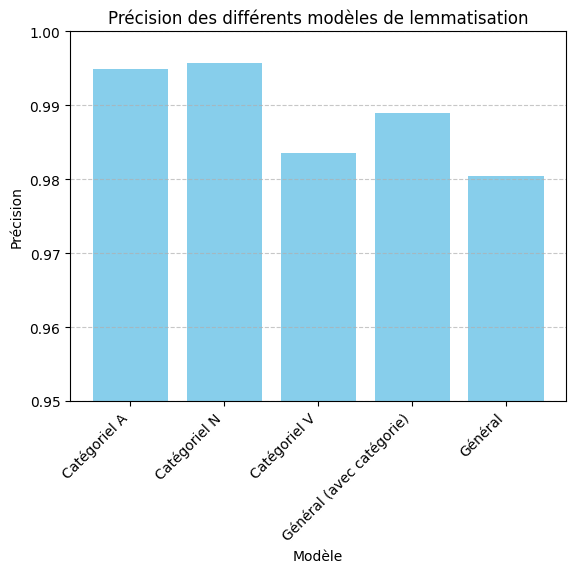

In [ ]:
import matplotlib.pyplot as plt

# données : modèles et précisions correspondantes
modeles = ['Catégoriel A', 'Catégoriel N', 'Catégoriel V', 'Général (avec catégorie)', 'Général']
precisions = [0.9949, 0.9957, 0.9835, 0.989, 0.9804]

plt.bar(modeles, precisions, color='skyblue')

plt.xlabel('Modèle')
plt.ylabel('Précision')
plt.title('Précision des différents modèles de lemmatisation')

# limiter l'axe des ordonnées entre 0.95 et 1
plt.ylim(0.95, 1)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# IV. Néologisme

Le lemmatiseur est en théorie capable de traiter des
mots qu'il n'a jamais vu et en particulier des mots nouveaux (des néologismes). Imaginez des nouveaux mots des trois catégories étudiées
et testez votre lemmatiseur dessus.

In [ ]:
x_test, y_test = lecture_fichier_general('data/neologisme.txt')

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10869742929935455
Test accuracy: 0.972000002861023


# IV. 2. Généralisation

Le processus de lemmatisation est en bonne partie
régulier, est ce que le lemmatiseur a besoin de beaucoup de données pour apprendre ces régularités ?

Prenons notre dernier lemmatiseur général et sélectionnons seulement une partie des données d'apprentissage (grâce à un pourcentage).

In [ ]:
def lecture_fichier_p(fichier, pourcentage):
  try:
    fic = open(fichier, 'r')
  except IOError:
    print("Le fichier", fichier, "n'existe pas")
    return None
  LX = []
  LY = []

  lines_AVN = []  # liste contenant les lignes des catégories 'A', 'V', 'N'

  for line in fic:
    line = line.strip()
    (forme, lemme, cat) = line.split()
    if cat in ['A', 'V', 'N']:
      lines_AVN.append(line)

  nb_lignes_lire = int(len(lines_AVN) * pourcentage)
  for line in lines_AVN[:nb_lignes_lire]:
    line = line.strip()
    (forme, lemme, cat) = line.split()
    X = []
    for c in forme:
      oneHot = ed.oneHotEncode(c)
      X.append(oneHot)
    LX.append(X)
    Y = []
    for c in lemme:
      oneHot = ed.oneHotEncode(c)
      Y.append(oneHot)
    LY.append(Y)

  return np.array(LX), np.array(LY)

# il a fallu modifier la fonction lecture_fichier pour prendre un pourcentage des lignes
# parmi celles des 3 catégories d'intérêt, et non simplement un pourcentage de tout le fichier
# (d'où la création d'une liste lines_AVN)

In [ ]:
x_train, y_train = lecture_fichier_p('data/lemmatisation_train.txt',0.5)

In [ ]:
print(x_train.shape)
print(y_train.shape)
# on peut vérifier qu'on a bien x % du nombre de lignes 114154 (nombres de lignes des catégories A, V ou N)

(11415, 25, 66)
(11415, 25, 66)


In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Activation, Dropout

input_length = 25 # nb caractères sur chaque colonne (le mot et les #)
input_dim = 66 # nb caractères alphabet

model = Sequential()
model.add(GRU(
    units = 64,
    activation="tanh", # fonction d'activation de l'état interne
    recurrent_activation="sigmoid", # fonction d'activation des filtres
    use_bias=True, # ajout d'un biais
    return_sequences=True,
    return_state=False,
    input_shape=(input_length, input_dim)))

model.add(Dense(units=66, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train,epochs=5, batch_size=128)

Epoch 1/5
446/446 [==============================] - 6s 7ms/step - loss: 0.8247 - accuracy: 0.8571
Epoch 2/5
446/446 [==============================] - 3s 7ms/step - loss: 0.1705 - accuracy: 0.9626
Epoch 3/5
446/446 [==============================] - 3s 7ms/step - loss: 0.1198 - accuracy: 0.9695
Epoch 4/5
446/446 [==============================] - 4s 8ms/step - loss: 0.0936 - accuracy: 0.9753
Epoch 5/5
446/446 [==============================] - 3s 7ms/step - loss: 0.0796 - accuracy: 0.9780


In [ ]:
x_test, y_test = lecture_fichier_p('data/lemmatisation_test.txt',0.5)

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07581980526447296
Test accuracy: 0.9789737462997437


Courbe précision en fonction du pourcentage

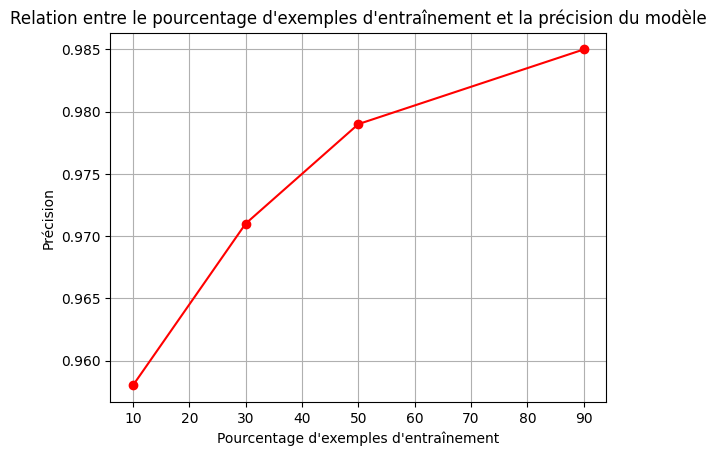

In [ ]:
import matplotlib.pyplot as plt

# Pourcentages d'exemples d'entraînement et précisions correspondantes
pourcentages = [10, 30, 50, 90]
accuracy_values = [0.958, 0.971, 0.979, 0.985]

# Tracer la courbe de précision en fonction du pourcentage
plt.plot(pourcentages, accuracy_values, marker='o', linestyle='-', color='r')

# Ajouter des étiquettes et un titre au graphique
plt.xlabel('Pourcentage d\'exemples d\'entraînement')
plt.ylabel('Précision')
plt.title('Relation entre le pourcentage d\'exemples d\'entraînement et la précision du modèle')

# Afficher le graphique
plt.grid(True)
plt.show()